In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_color_map
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import torch
from torch import nn, optim, utils
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import models
import numpy as np
import os
import time
from tqdm import tqdm
import copy
from tensorboardX import SummaryWriter
from torchsummary import summary
from PIL import Image
from skimage.transform import resize

In [2]:
data_dir = '/home/samael/github/image_generation/'
worker = 16
batch_size = 32
image_size = 512
num_epochs = 10
lr = 1e-2
momentum = 0.9
ngpu = 2
writer = SummaryWriter(log_dir='log')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: vdatasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=worker) for x in ['train', 'val']}
print('Initialized!')

Initializing Datasets and Dataloaders...
Initialized!


In [4]:
device = torch.device('cuda:0')

In [5]:
def norm_image(image):
    min_val = torch.min(image)
    max_val = torch.max(image)
    return (image - min_val) / (max_val - min_val)

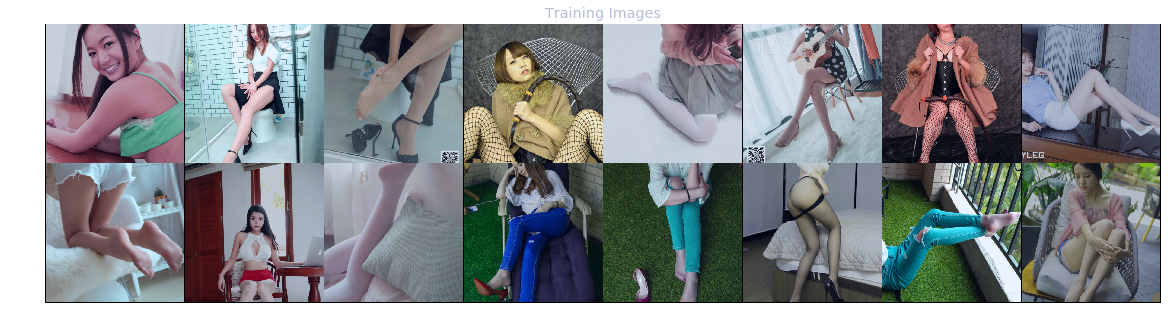

In [6]:
real_batch = next(iter(dataloaders_dict['train']))
val_batch = next(iter(dataloaders_dict['val']))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [8]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

In [9]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [11]:
# resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 7)
# resnet18 = resnet18.to(device)
# if ngpu > 1:
#     resnet18 = nn.DataParallel(resnet18, list(range(ngpu)))

In [12]:
# resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 7)
# resnet34 = resnet34.to(device)
# if ngpu > 1:
#     resnet34 = nn.DataParallel(resnet34, list(range(ngpu)))

In [13]:
# resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 7)
# resnet50 = resnet50.to(device)
# if ngpu > 1:
#     resnet50 = nn.DataParallel(resnet50, list(range(ngpu)))

In [14]:
resnet50 = models.resnet50(pretrained=True)
resnet50.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet50.fc = nn.Linear(512 * 4, 7)
resnet50 = resnet50.to(device)
summary(resnet50, (3, 512, 512))
if ngpu > 1:
    resnet50 = nn.DataParallel(resnet50, list(range(ngpu)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [15]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.module._modules.items():
            if module_pos == 'fc':
                continue
            x = module(x)
            if module_pos == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        # Forward pass on the classifier
        x = x.view(x.size(0), -1)
        x = self.model.module.fc(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output.cuda(), retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
#         cam = resize(cam, (512, 512))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        return cam

def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap.resize(org_im.size, resample=1))
    return no_trans_heatmap, heatmap_on_image

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iterations = 0
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                if phase == 'train':
                    iterations += 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if (iterations+1) % 1000 == 0:
                    lr *= 0.1
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                writer.add_scalar('Eval/Accuracy', epoch_acc, epoch + 1)
                writer.add_scalar('Eval/Loss', epoch_loss, epoch + 1)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch + 1)
                writer.add_scalar('Train/Loss', epoch_loss, epoch + 1)
        
        time_elapsed = time.time() - since
        hour = time_elapsed // 3600
        minute = (time_elapsed - hour * 3600) // 60
        second = (time_elapsed - hour * 3600) % 60
        writer.add_scalar('lr', lr, epoch + 1)
        print("Training elapsed {:.0f}h {:.0f}m {:.0f}s".format(hour, minute, second))
        print()
    
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [17]:
optimizer_ft = optim.SGD(resnet50.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [18]:
model_ft, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model(resnet50, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.7985 Acc: 0.7274
val Loss: 1.7621 Acc: 0.6263
Training elapsed 0h 1m 49s

Epoch 2/10
----------
train Loss: 0.3309 Acc: 0.8888
val Loss: 1.9713 Acc: 0.6598
Training elapsed 0h 3m 36s

Epoch 3/10
----------
train Loss: 0.2721 Acc: 0.9098
val Loss: 2.3300 Acc: 0.7397
Training elapsed 0h 5m 22s

Epoch 4/10
----------
train Loss: 0.1716 Acc: 0.9405
val Loss: 1.4691 Acc: 0.6624
Training elapsed 0h 7m 10s

Epoch 5/10
----------
train Loss: 0.1797 Acc: 0.9407
val Loss: 2.7045 Acc: 0.7371
Training elapsed 0h 8m 56s

Epoch 6/10
----------
train Loss: 0.1292 Acc: 0.9542
val Loss: 1.3929 Acc: 0.7268
Training elapsed 0h 10m 43s

Epoch 7/10
----------
train Loss: 0.1322 Acc: 0.9579
val Loss: 1.3320 Acc: 0.6856
Training elapsed 0h 12m 30s

Epoch 8/10
----------
train Loss: 0.1263 Acc: 0.9571
val Loss: 2.1119 Acc: 0.7732
Training elapsed 0h 14m 17s

Epoch 9/10
----------
train Loss: 0.0944 Acc: 0.9675
val Loss: 1.9072 Acc: 0.7371
Training elapsed 0h 16m 4s

Epoch 1

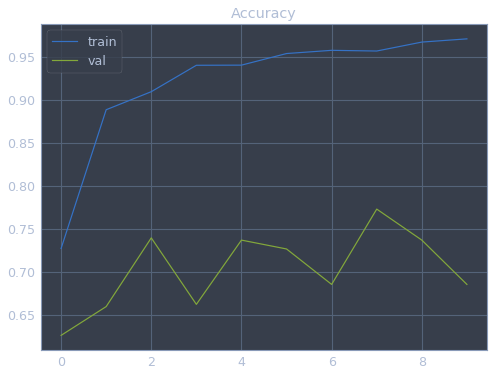

In [19]:
plt.figure(figsize=(8, 6))
plt.title('Accuracy')
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.legend(['train', 'val'])
plt.show()

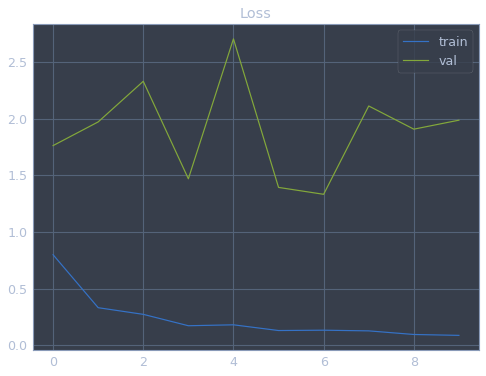

In [20]:
plt.figure(figsize=(8, 6))
plt.title('Loss')
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.legend(['train', 'val'])
plt.show()

In [21]:
classes = ['black_tights', 'fishnet', 'flesh_colored', 'other_colors', 'others', 'pants', 'white_tights']

In [22]:
train_prob, train_pred = torch.max(F.softmax(resnet50(real_batch[0][:9].to(device)), dim=1), 1)
val_prob, val_pred = torch.max(F.softmax(resnet50(val_batch[0][:9].to(device)), dim=1), 1)

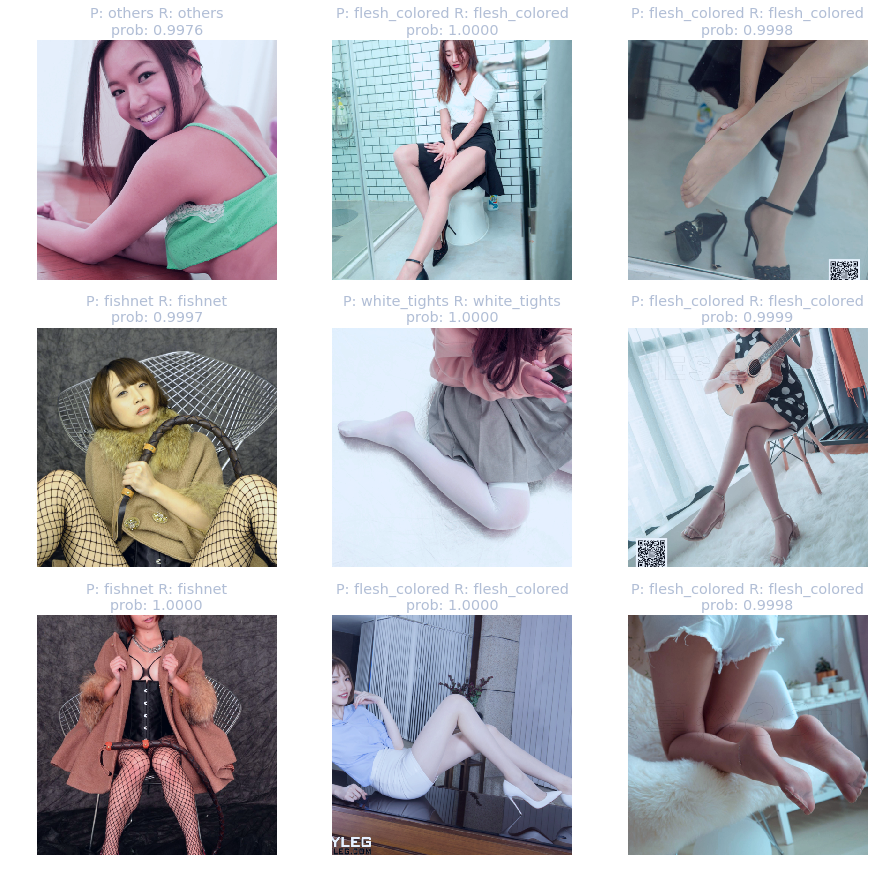

In [23]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: '+classes[train_pred[i]] + " R: " + classes[real_batch[1][i]] + '\n' + 'prob: %.4f' %(train_prob[i]))
    plt.imshow(norm_image(real_batch[0][i]).permute(1, 2, 0))
plt.show()

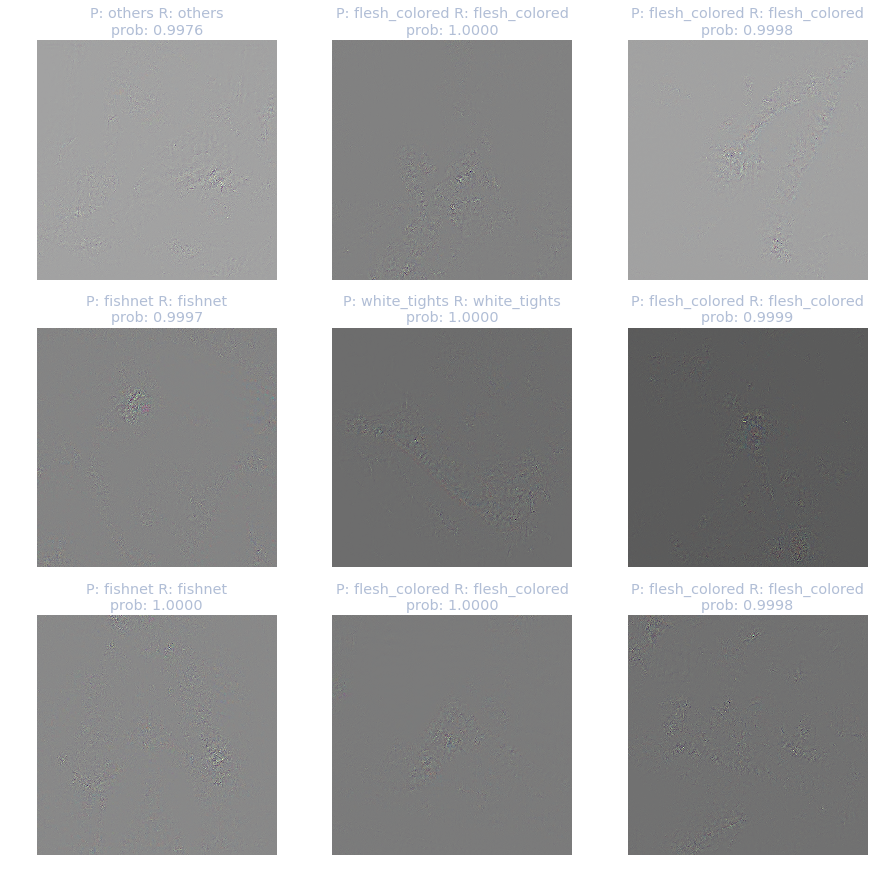

In [24]:
data = real_batch[0][:9]
data.requires_grad = True
out = resnet50(data)
loss = criterion(out, real_batch[1][:9].to(device))
loss.backward()
saliency = data.grad.data

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[train_pred[i]] + " R: " + classes[real_batch[1][i]] + '\n' + 'prob: %.4f' %(train_prob[i]))
    plt.imshow(norm_image(saliency[i]).permute(1, 2, 0))
plt.show()

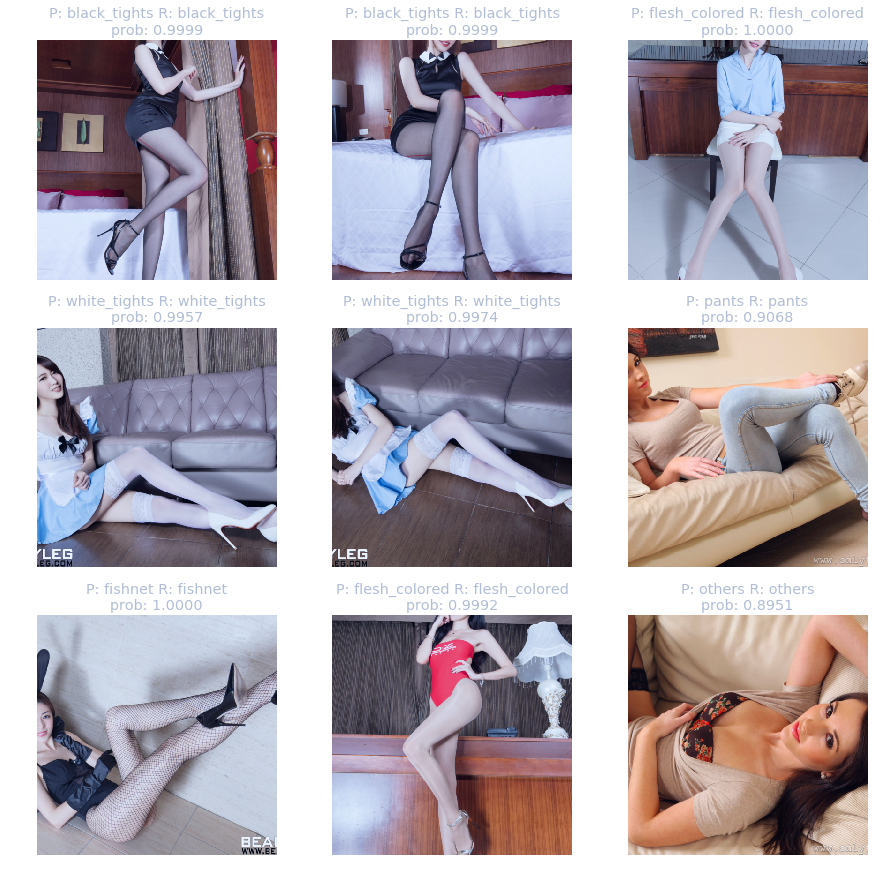

In [25]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[val_pred[i]] + " R: " + classes[val_batch[1][i]] + '\n' + 'prob: %.4f' %(val_prob[i]))
    plt.imshow(norm_image(val_batch[0][i]).permute(1, 2, 0))
plt.show()

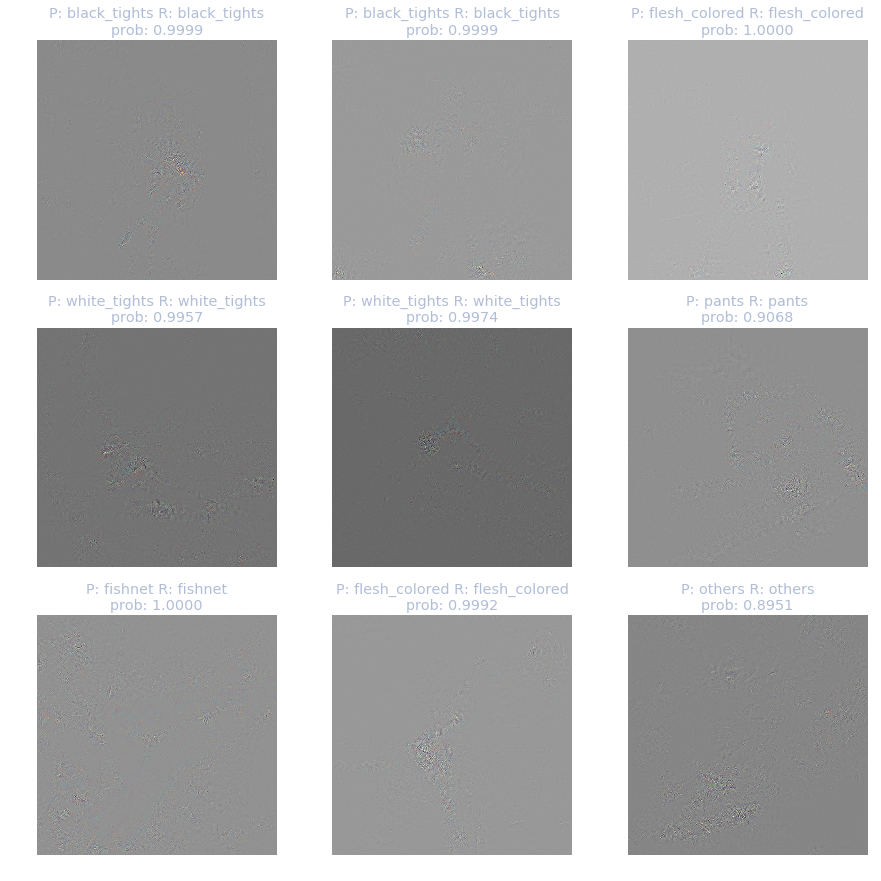

In [26]:
data = val_batch[0][:9]
data.requires_grad = True
out = resnet50(data)
loss = criterion(out, val_batch[1][:9].to(device))
loss.backward()
saliency = data.grad.data

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[val_pred[i]] + " R: " + classes[val_batch[1][i]] + '\n' + 'prob: %.4f' %(val_prob[i]))
    plt.imshow(norm_image(saliency[i]).permute(1, 2, 0))
plt.show()

In [27]:
grad_cam = GradCam(resnet50, target_layer='layer4')

In [28]:
cam = grad_cam.generate_cam(data[0].unsqueeze_(0).cuda(), 6)

In [29]:
img = Image.fromarray(np.uint8(norm_image(data[0]).permute(1, 2, 0).data.numpy()*255))

In [30]:
no_trans_heatmap, heatmap_on_img = apply_colormap_on_image(img, cam, 'hsv')

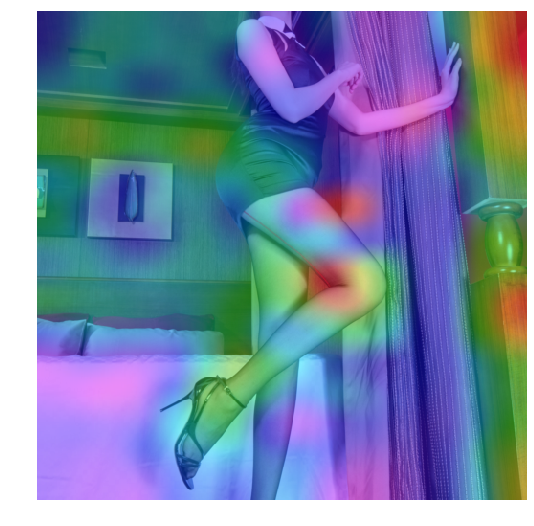

In [31]:
plt.figure(figsize=(9, 9))
plt.imshow(heatmap_on_img)
plt.grid(False)
plt.axis('off')
plt.show()